<a href="https://colab.research.google.com/github/kSahatova/AA2024/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation and import of relevant packages

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.4 MB/s eta 0:00:00


In [ ]:
import os
import itertools
import numpy as np
import pandas as pd
import category_encoders

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from category_encoders.count import CountEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, auc, roc_curve, roc_auc_score
from sklearn.metrics import RocCurveDisplay

import warnings
%matplotlib inline

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Only run when the file is uploaded to GoogleColab as it mounts your GoogleDrive to the 'content' folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", UserWarning)

pd.set_option('display.max_columns', 50)
sns.set_theme()

In [ ]:
palette = sns.color_palette().as_hex()

# Reading and splitting the data

In [ ]:
# insert your path to dir_path
dir_path = '/content/drive/MyDrive/AA2024/assignment1/data'


train_df = pd.read_csv(os.path.join(dir_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(dir_path, 'test.csv'))

Check of missing values in the train and test sets.

In [ ]:
print('Number of rows with missing values in the trining set:', train_df[train_df.isna().any(axis=1)].shape[0])
print('Number of rows with missing values in the test set:', test_df[test_df.isna().any(axis=1)].shape[0])

Number of rows with missing values in the trining set: 4
Number of rows with missing values in the test set: 1


Splitting 20% of the training data into training and validation sets

In [ ]:
predictors =  [col for col in train_df.columns if col !='target']
X = train_df.loc[:, predictors]
X_test = test_df.loc[:, predictors]

y = train_df.loc[:, 'target']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y,
                                                  test_size=0.2,
                                                  random_state=42)

In [ ]:
train_ids, val_ids, test_ids = X_train['id'], X_val['id'], X_test['id']

X_train = X_train.drop(['Connect_Date', 'id'], axis=1)
X_val = X_val.drop(['Connect_Date', 'id'], axis=1)
X_test = X_test.drop(['Connect_Date', 'id'], axis=1)

print('Shape of the train set: ', X_train.shape)
print('Shape of the validation set: ', X_val.shape)
print('Shape of the test set: ', X_test.shape)

Shape of the train set:  (4035, 36)
Shape of the validation set:  (1009, 36)
Shape of the test set:  (1682, 36)


Preliminary data exploration

In [ ]:
train_df.head()

,Gender,Age,Connect_Date,L_O_S,Dropped_Calls,tariff,Handset,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,Nat_call_cost_Sum,AvePeak,AveOffPeak,AveWeekend,National_calls,National mins,AveNational,All_calls_mins,Dropped_calls_ratio,Usage_Band,Mins_charge,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,Tariff_OK,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,high Dropped calls,No Usage,target,id
0,F,50.0,20/05/98,29.200000,2.0,Play 100,BS210,62.0,153.000000,185.0,438.600001,4.0,29.0,126.002615,2.045727,2.467742,2.370811,7.25,251.0,620.600001,2.472510,746.602616,0.003984,Med,20.600001,9.930712,2.045727,52.446773,112.386773,OK,0.150531,0.246536,0.706735,0.046729,0.203034,F,F,0,K262360
1,M,25.0,16/12/96,46.533333,1.0,CAT 100,ASAD90,146.0,718.800000,98.0,164.700000,4.0,37.2,251.580636,41.072379,4.923288,1.680612,9.30,248.0,920.700000,3.712500,1172.280636,0.002016,Med,320.700000,12.807103,41.072380,116.546571,221.546571,OK,0.188988,0.780710,0.178886,0.040404,0.273249,F,F,1,K170160
2,F,46.0,27/08/97,38.066667,1.0,CAT 50,WC95,160.0,322.800000,7.0,123.900000,0.0,0.0,91.584877,21.575073,2.017500,17.700000,0.00,167.0,446.700000,2.674850,538.284877,0.002994,MedLow,146.700000,12.226326,17.936021,45.411484,128.811484,OK,0.239300,0.722633,0.277367,0.000000,0.205025,F,F,0,K331610
3,F,59.0,13/07/98,27.400000,1.0,CAT 50,BS110,84.0,317.400001,57.0,161.699999,0.0,0.0,23.998036,20.950771,3.778571,2.836842,0.00,141.0,479.100000,3.397872,503.098036,0.003546,MedLow,179.100000,11.624922,20.820235,28.019646,111.419646,OK,0.221467,0.662492,0.337508,0.000000,0.050090,F,F,0,K332460
4,F,25.0,08/01/99,21.433333,1.0,Play 300,WC95,14.0,309.600000,326.0,637.800000,6.0,14.4,87.051515,0.000000,22.114286,1.956442,2.40,346.0,961.800000,2.779769,1048.851515,0.001445,Med,-838.200000,9.403618,0.000000,34.820606,112.760606,OK,0.107509,0.321896,0.663132,0.014972,0.090509,F,F,0,K394220


In [ ]:
train_df.dtypes

Gender                     object
Age                       float64
Connect_Date               object
L_O_S                     float64
Dropped_Calls             float64
tariff                     object
Handset                    object
Peak_calls_Sum            float64
Peak_mins_Sum             float64
OffPeak_calls_Sum         float64
OffPeak_mins_Sum          float64
Weekend_calls_Sum         float64
Weekend_mins_Sum          float64
International_mins_Sum    float64
Nat_call_cost_Sum         float64
AvePeak                   float64
AveOffPeak                float64
AveWeekend                float64
National_calls            float64
National mins             float64
AveNational               float64
All_calls_mins            float64
Dropped_calls_ratio       float64
Usage_Band                 object
Mins_charge               float64
call_cost_per_min         float64
actual call cost          float64
Total_call_cost           float64
Total_Cost                float64
Tariff_OK     

In [ ]:
train_df.describe()

,Age,L_O_S,Dropped_Calls,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,Nat_call_cost_Sum,AvePeak,AveOffPeak,AveWeekend,National_calls,National mins,AveNational,All_calls_mins,Dropped_calls_ratio,Mins_charge,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,target
count,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5040.000000,5044.000000,5040.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000
mean,31.384417,33.626890,2.677042,239.154441,708.610393,104.080293,312.420299,16.487510,50.139360,170.310248,19.433408,8.677779,8.720703,5.758751,359.722244,1071.170052,4.117578,1241.480300,0.007445,68.572907,10.092345,19.289973,73.909497,187.082344,0.168484,0.609938,0.327813,0.061456,0.162820,0.147700
std,12.767989,14.041931,3.427875,239.627055,503.964199,97.868704,199.094991,16.379353,36.051349,142.238289,28.179154,33.860203,23.948572,9.950477,259.621742,543.766236,3.713455,636.746325,0.019773,477.166180,2.105534,28.161217,60.377401,82.471189,0.078024,0.223795,0.209852,0.063664,0.104220,0.354838
min,12.000000,9.533333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1483.200000,2.000000,0.000000,0.000000,59.940000,0.048998,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,21.266667,0.000000,59.000000,307.800001,28.000000,147.525000,4.000000,22.800000,65.511122,0.000000,1.998552,1.963418,1.882658,170.000000,665.700000,2.226314,769.666731,0.000000,-104.400001,8.578771,0.000000,32.306809,123.926851,0.134453,0.467401,0.165634,0.021097,0.079444,0.000000
50%,29.000000,33.583334,1.000000,161.000000,611.699999,73.000000,293.699999,12.000000,44.400000,132.281821,8.063094,2.915522,2.949500,2.822479,297.000000,998.099999,2.976979,1141.279249,0.002304,75.900001,9.513941,7.800333,58.122962,173.505141,0.154474,0.655549,0.286238,0.043909,0.158947,0.000000
75%,39.000000,45.866667,2.000000,343.000000,1015.950000,156.000000,447.000000,24.000000,72.000000,236.113750,29.085798,5.986867,5.779012,5.300000,484.000000,1405.650001,4.513459,1613.921676,0.006897,284.474999,11.749149,28.747465,99.011752,232.132750,0.179141,0.782501,0.459535,0.080634,0.244624,0.000000
max,80.000000,58.200000,15.000000,1626.000000,2901.600001,560.000000,1091.099999,124.000000,205.000000,977.723297,190.464195,1175.400000,489.600000,149.400000,1939.000000,3423.300000,55.569811,4109.414942,0.500000,2223.300000,21.734694,190.464194,463.233885,613.233885,1.357564,1.000000,1.000000,0.797546,2.601223,1.000000


# Data visualization

A proper data visualization is considered a part of Exploratory Data Analysis. It allows us to derive more insights about the types of features, their distributions, and statistics from the visual representation.  

In [ ]:
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

sns.set_theme()

In [ ]:
palette = sns.color_palette().as_hex()

In [ ]:
gender_labels = ['F', 'M']

fig = go.Figure(data=[go.Pie(labels=gender_labels,
                             values=train_df['Gender'].value_counts())])
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    template='seaborn',
    autosize=False,
    width=600,
    height=500,
    title_text="Gender Distribution")

fig.show()

In [ ]:
target_labels = ['No', 'Yes']

fig = go.Figure(data=[go.Pie(labels=target_labels,
                      values=train_df['target'].value_counts())])

fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16,
                  marker=dict(colors=palette[2:]))
fig.update_layout(
    template='seaborn',
    autosize=False,
    width=600,
    height=500,
    title_text="Customers Distribution")

fig.show()

In [ ]:
f_0, m_0 = train_df["target"][train_df["target"]==0].groupby(by=train_df["Gender"]).count()
print('Number of non-churn female and male customers\n', f'F: {f_0}, M: {m_0}')

f_1, m_1 = train_df["target"][train_df["target"]==1].groupby(by=train_df["Gender"]).count()
print('Number of churn female and male customers\n', f'F: {f_1}, M: {m_1}')

Number of non-churn female and male customers
 F: 2246, M: 2053
Number of churn female and male customers
 F: 351, M: 394


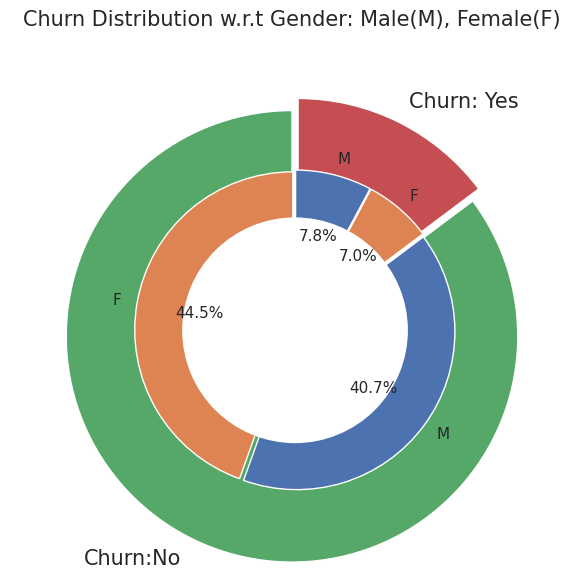

In [ ]:
non_churn, churn = train_df['target'].value_counts()

plt.figure(figsize=(6, 6))

labels =["Churn:No", "Churn: Yes"]
values = [non_churn, churn]

labels_gender = ["F","M", "F","M"]
sizes_gender = [f_0, m_0, f_1, m_1]


churn_colors = palette[2:4] # ['#66b3ff', '#ff6666']
colors_gender = [palette[1], palette[0]] # ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']

explode = (0.3,0.3)
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}

plt.pie(values, labels=labels, pctdistance=1.08,
        labeldistance=1.1, colors=churn_colors, startangle=90, frame=True,
        explode=explode, radius=10, textprops=textprops, counterclock=True)

plt.pie(sizes_gender, labels=labels_gender, colors=colors_gender,
        startangle=90, autopct='%1.1f%%',
        explode=explode_gender, radius=7, textprops={"fontsize":11},
        counterclock=True)

centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn Distribution w.r.t Gender: Male(M), Female(F)',
          fontsize=15, y=1.1)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
def plot_column_distribution(dataframe, column, palette):
  colors_map = {k: v for k, v in zip(dataframe.loc[:, column].unique(),
                                     palette)}
  fig = px.histogram(dataframe, x="target", color=column, barmode="group",
                    title=f"<b>Customer '{column}' distribution<b>",
                    color_discrete_map=colors_map);

  fig.update_layout(template='seaborn', width=700, height=500, bargap=0.1)
  fig.update_xaxes(categoryorder='trace')

  fig.show();

In [ ]:
plot_column_distribution(train_df, 'tariff', palette)

In [ ]:
plot_column_distribution(train_df, 'Tariff_OK', palette)

In [ ]:
plot_column_distribution(train_df, 'Handset', palette)

In [ ]:
def return_letter(word):
  letters = ''
  for l in word:
    if not l.isdigit():
      letters += l
  return letters


handset_df = train_df.loc[:, ['Handset', 'target']]
handset_df['Handset'] = handset_df['Handset'].apply(return_letter)

In [ ]:
plot_column_distribution(handset_df, 'Handset', palette)

In [ ]:
plot_column_distribution(train_df, 'No Usage', palette)

In [ ]:
plot_column_distribution(train_df, 'Usage_Band', palette)

In [ ]:
binned_age = pd.cut(train_df['Age'], bins=5)
age_df = pd.concat([binned_age, train_df['target']], axis=1)

In [ ]:
plot_column_distribution(age_df, 'Age', palette)

In [ ]:
plot_column_distribution(train_df, 'high Dropped calls', palette)

## Outliers check

Here we check the descriptive statistics of the continuous features using boxplots. Analysis of feature correlations is also an important step to eliminate redundant interconnections and correlated predictors.

In [ ]:
train_df_cont = train_df.select_dtypes(exclude=[object])

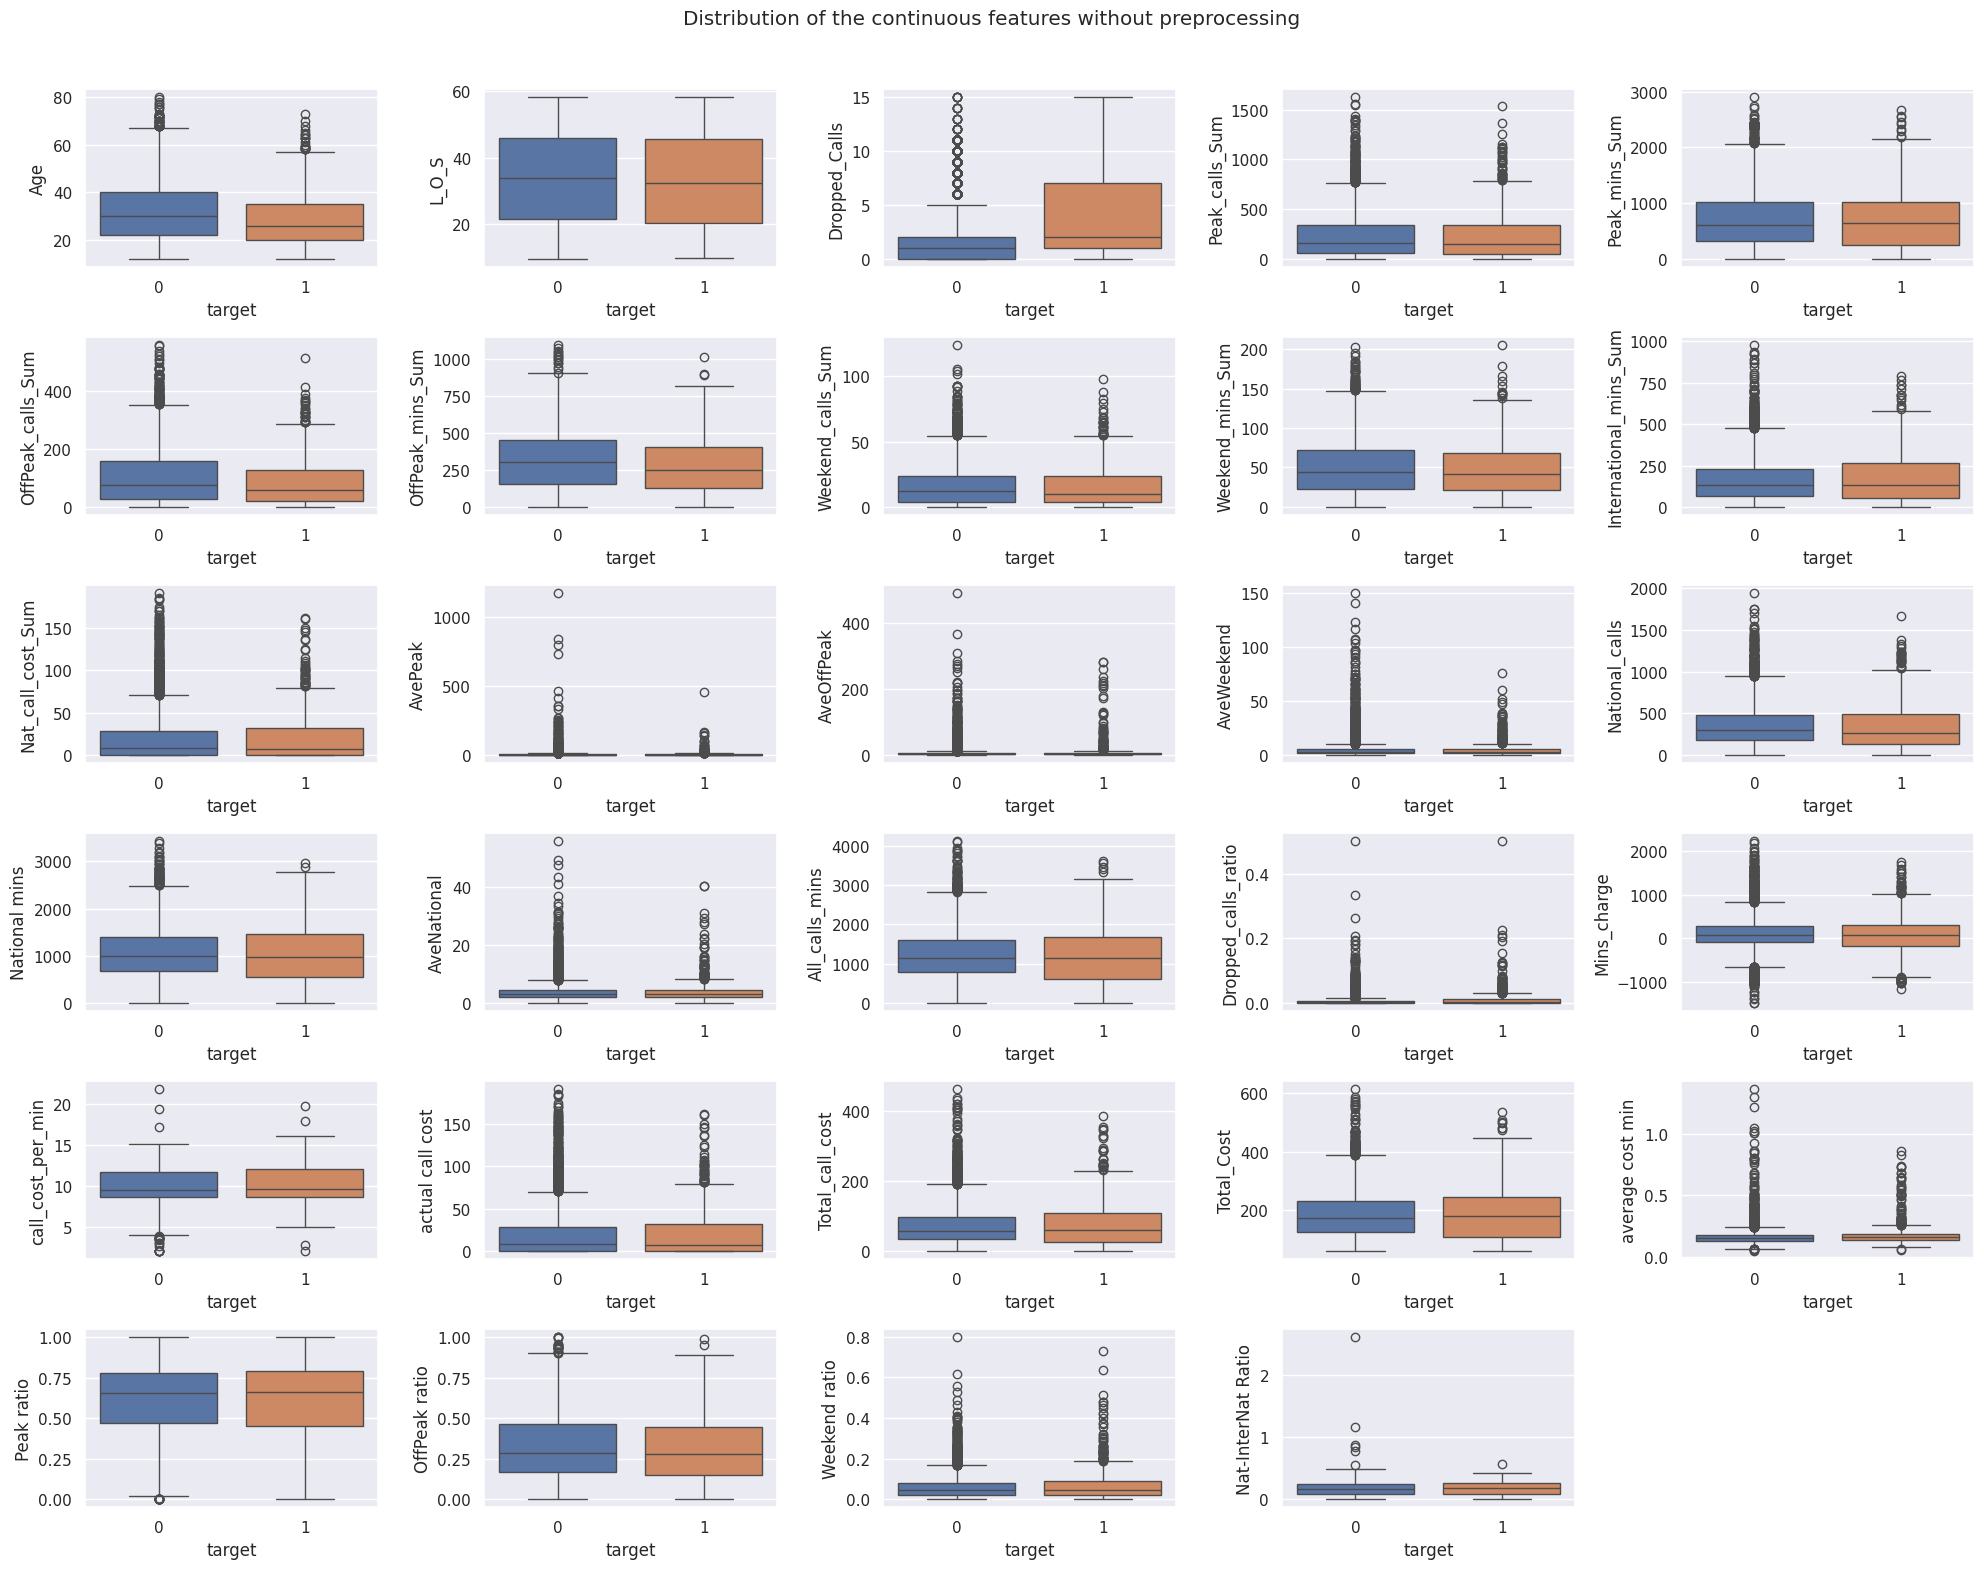

In [ ]:
rows = 6
cols = int(np.ceil((train_df_cont.shape[1]) / rows))

fig = plt.figure(figsize=(20, 16))

for i, k in enumerate(train_df_cont.columns):
    try:
      if k != 'target':
        ax = plt.subplot(rows,cols,i+1)
        sns.boxplot(x='target', y=train_df_cont.loc[:, k],
                    ax=ax, data=train_df_cont, hue='target')
        ax.legend([],[], frameon=False)
    except IndexError:
        pass

plt.suptitle('Distribution of the continuous features without preprocessing')
fig.tight_layout();
fig.subplots_adjust(top=0.93)

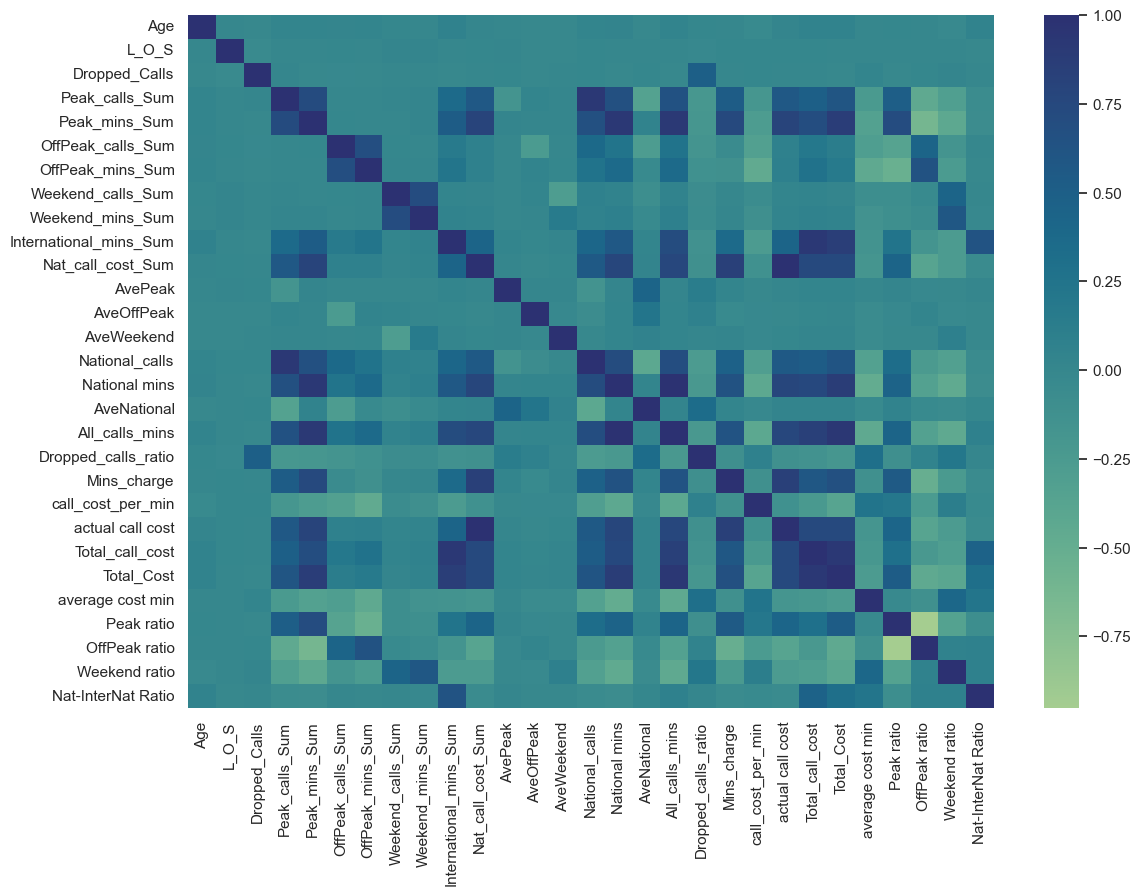

In [ ]:
features_corrm = train_df_cont.loc[:, train_df_cont.columns!='target'].corr()

fig, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(features_corrm, ax=ax,annot=False, cmap="crest", fmt=".1f");

# Preprocessing pipeline

Having both numeric and categorical features, we need to implement corresponding preprocessing steps for each type.

In [ ]:
def return_letter(word):
  letters = ''
  for l in word:
    if not l.isdigit():
      letters += l
  return letters

In [ ]:
X_train['Handset'] = X_train['Handset'].apply(return_letter)
X_val['Handset'] = X_val['Handset'].apply(return_letter)
X_test['Handset'] = X_test['Handset'].apply(return_letter)

For the feature 'Age' we applied binning to transform it from numeric to categorical.

In [ ]:
# Define the bins based on training set
bins_train = pd.cut(X_train['Age'], bins=5, retbins=True)[1]

# To ease the following work, the binned categories have been renamed
labels = ['group1', 'group2', 'group3', 'group4', 'group5']

# Bin all sets using the calculated bins
X_train['Age'] = pd.cut(X_train['Age'], bins=bins_train,
                        labels=labels, include_lowest=True)
X_val['Age'] = pd.cut(X_val['Age'], bins=bins_train,
                      labels=labels, include_lowest=True)
X_test['Age'] = pd.cut(X_test['Age'], bins=bins_train,
                       labels=labels, include_lowest=True)

In [ ]:
numeric_features = X_train.select_dtypes(exclude=['object', 'category']).columns

In [ ]:
ohe_columns = ['Age', 'Gender', 'high Dropped calls', 'No Usage', 'Tariff_OK']
count_enc_columns = ['Handset', 'tariff']
ord_enc_columns = ['Usage_Band']

categories = [['Low', 'MedLow', 'Med', 'MedHigh', 'High']]

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class OrdinalEncoderForColumn(BaseEstimator, TransformerMixin):
    def __init__(self, column, categories):
        self.column = column
        self.categories = categories
        self.ordinal_encoder = OrdinalEncoder(categories=self.categories,
                                              handle_unknown='error')

    def fit(self, X, y=None):
        if isinstance(X, np.ndarray):
          X = pd.DataFrame(X, columns=self.column)
        self.ordinal_encoder.fit(X[self.column].values.reshape(-1, 1))
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
          X = pd.DataFrame(X, columns=self.column)
        X_encoded = X.copy()
        X_encoded[self.column] = self.ordinal_encoder.transform(X[self.column].values.reshape(-1, 1))
        return X_encoded

    def get_feature_names_out(self, input_features=None):
        return self.column

In [ ]:
# All numeric features will be imputed and scaled using Robust Scaler
# which is insensitive to outliers

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())])

preprpcessor_1 = ColumnTransformer(
    transformers=[('numeric', num_transformer, numeric_features)])

# The passed columns will be one-hot encoded
preprpcessor_2 = ColumnTransformer(
    transformers=[('cat1', OneHotEncoder(handle_unknown='ignore'),
                   pd.Index(ohe_columns))])

# Here count encoding is applied
preprpcessor_3 = ColumnTransformer(
    transformers=[('cat2', CountEncoder(),
                   pd.Index(count_enc_columns))])

# The same transformer for ordinal encoding with the custom class
cat4_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoderForColumn(ord_enc_columns, categories))])

preprpcessor_4 = ColumnTransformer(
    transformers=[('cat3', cat4_transformer, ord_enc_columns)])


# Combination of all transformers with FeatureUnion
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('preprocessor1', preprpcessor_1),
        ('preprocessor2', preprpcessor_2),
        ('preprocessor3', preprpcessor_3),
        ('preprocessor4', preprpcessor_4)
    ]))
])

In [ ]:
X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)
X_test_transformed = pipeline.transform(X_test)

In [ ]:
# The output of the preprocessing pipeline is ndarray that doesn't contain column names
# At this step, we transform the preprocessed data back to dataframes
transformed_column_names = []

for transformer in pipeline.named_steps['features'].transformer_list:
  col_names = transformer[1].get_feature_names_out()
  transformed_column_names.extend([col_name.split('__')[1]
                                   for col_name in col_names])

In [ ]:
X_train_transformed = pd.DataFrame(X_train_transformed,
                                   columns=transformed_column_names)
X_val_transformed = pd.DataFrame(X_val_transformed,
                                 columns=transformed_column_names)
X_test_transformed = pd.DataFrame(X_test_transformed,
                                  columns=transformed_column_names)

## Drop correlated features

The analysis of correlated features clearly indicates a dependence between the features tracking call frequency and call duration in minutes. Therefore, we have decided to exclude the number of calls from certain metrics and only retain their duration, represented in minutes, to reduce redundancy in the model.

In [ ]:
drop_columns = ['Peak_calls_Sum',
                'OffPeak_calls_Sum',
                'Weekend_calls_Sum',
                'National_calls',
                'Total_call_cost',
                'No Usage_F', 'No Usage_T']

In [ ]:
X_train_red = X_train_transformed.drop(drop_columns, axis=1)
X_val_red = X_val_transformed.drop(drop_columns, axis=1)
X_test_red = X_test_transformed.drop(drop_columns, axis=1)

# Experiments

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier

from xgboost import XGBClassifier

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, auc, RocCurveDisplay

from tqdm import tqdm

import lightgbm as lgb
from lightgbm import LGBMClassifier


In [ ]:
# These are functions to estimate performance of the model

def calc_auc(model, data, targets):
  """
  Calculates AUC generating predictions
  """
  predictions = model.predict_proba(data)[:, 1]
  print('AUC: ', roc_auc_score(targets, predictions))


def check_top20_churners(model, data, ids, verbose=True):
  """
  Predicts probability of being churn and check average cost for top 20 users
  """
  y_pred = model.predict_proba(data)[:, 1]
  y_pred = pd.DataFrame(y_pred, columns=['target_prob'])
  ids_df = pd.DataFrame(ids.values.reshape(-1, 1), columns=['id'])

  data = data.reset_index(drop=True)
  y_pred = y_pred.reset_index(drop=True)
  temp = pd.concat([ids_df, data['average cost min'], y_pred], axis=1)
  temp['weighted_prob']= 0.9*temp['target_prob'] + 0.1*temp['average cost min']
  top20 = temp.sort_values(by=['weighted_prob'], ascending=False)[:20]

  result = top20['average cost min'].sum()
  if verbose:
    print('Sum of retained profitability for top 20 users: ', result)

  return result

The first experiment includes comparison of performance of the number of ensemble-based models using validation set.

In [ ]:
ensemble_classifiers = {'RF': RandomForestClassifier(),
                        'AdaBoost': AdaBoostClassifier(),
                        'BalancedRF': BalancedRandomForestClassifier(),
                        'EasyEnsemble': EasyEnsembleClassifier(),
                        'XGBoost': XGBClassifier(eval_metric='logloss',
                                                 objective='binary:logistic'),
                        'LightGBM': LGBMClassifier(verbosity=0)
}

ebm_metrics_scores = {}
fitted_classifiers = {}

for title, clf in tqdm(ensemble_classifiers.items()):
  clf.fit(X_train_red, y_train)
  fitted_classifiers[title] = clf

  y_train_pred =  clf.predict_proba(X_train_red)[:, 1]
  y_val_pred = clf.predict_proba(X_val_red)[:, 1]

  y_train_pred_t =  clf.predict(X_train_red)
  y_val_pred_t =  clf.predict(X_val_red)

  val_top20 = check_top20_churners(clf, X_val_red, val_ids, verbose=False)
  test_top20 = check_top20_churners(clf, X_test_red, test_ids, verbose=False)

  ebm_metrics_scores[title] = [roc_auc_score(y_train, y_train_pred),
                               roc_auc_score(y_val, y_val_pred),
                               f1_score(y_train, y_train_pred_t),
                               f1_score(y_val, y_val_pred_t),
                               val_top20, test_top20]

ebm_metrics_df = pd.DataFrame(ebm_metrics_scores.values(),
                              columns=['roc_auc_train', 'roc_auc_val',
                                       'f1_train', 'f1_val',
                                       'top20_val', 'top20_test'],
                              index=list(ebm_metrics_scores.keys()))
ebm_metrics_df

 83%|████████▎ | 5/6 [00:12<00:02,  2.47s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


,roc_auc_train,roc_auc_val,f1_train,f1_val,top20_val,top20_test
RF,1.000000,0.891689,0.999160,0.529148,160.356740,275.569928
AdaBoost,0.886571,0.847893,0.404819,0.343750,186.896878,276.891838
BalancedRF,0.996633,0.891513,0.758270,0.619423,170.565202,275.569928
EasyEnsemble,0.893248,0.848595,0.538717,0.529274,186.576110,276.891838
XGBoost,1.000000,0.894498,0.999160,0.548523,152.193410,264.651189
LightGBM,0.999983,0.914227,0.990686,0.619247,155.311069,263.599852


Following the requirements of the assignment, we evaluated the models using metrics that ensure their good performance (AUC) and meet business-oriented needs through the customized metric (profitability of the top 20 probable churn users). We go for LightGBM as that one did a very good job in previous iterations as well.

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Define parameter space for LightGBM
params = {
    "num_leaves": [30, 31, 32],  # Including default 31
    "max_depth": [-2,-1,0,1,2],     # Including default -1
    "learning_rate": [0.01, 0.05, 0.1],  # Neighbors of 0.05
    "reg_alpha": [0.4, 0.5,0.6],      # Neighbor of 0.5
    "reg_lambda": [0.0, 0.1, 0.5],
    "n_jobs": [-1],
    "random_state": [42],
}

lightgbm = LGBMClassifier(objective='binary', metric='auc', n_jobs=-1, random_state=42)

def negative_roc_auc_scorer(ground_truth, predicted):
    return -roc_auc_score(ground_truth, predicted)

grid_search = GridSearchCV(lightgbm, params, cv=StratifiedKFold(n_splits=5), scoring='neg_log_loss', verbose=1)
grid_search.fit(X_train_red, y_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 477, number of negative: 2751
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5666
[LightGBM] [Info] Number of data points in the train set: 3228, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147770 -> initscore=-1.752203
[LightGBM] [Info] Start training from score -1.752203
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 477, number of negative: 2751
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5664
[LightGBM] [Info] 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LGBMClassifier(metric='auc', n_jobs=-1,
                                      objective='binary', random_state=42),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [-2, -1, 0, 1, 2], 'n_jobs': [-1],
                         'num_leaves': [30, 31, 32], 'random_state': [42],
                         'reg_alpha': [0.4, 0.5, 0.6],
                         'reg_lambda': [0.0, 0.1, 0.5]},
             scoring='neg_log_loss', verbose=1)

In [ ]:
best_lgbm = grid_search.best_estimator_

In [ ]:
print('Best parameters: ', grid_search.best_estimator_.get_params())

Best parameters:  {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 30, 'objective': 'binary', 'random_state': 42, 'reg_alpha': 0.4, 'reg_lambda': 0.5, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'auc'}


In [ ]:
calc_auc(best_lgbm, X_val_red, y_val)
_ = check_top20_churners(best_lgbm, X_val_red, val_ids)
_ = check_top20_churners(best_lgbm, X_test_red, test_ids)

AUC:  0.9154518495395662
Sum of retained profitability for top 20 users:  151.78154817900813
Sum of retained profitability for top 20 users:  271.3379698069255


In [ ]:
def return_predictions(model, data, ids, verbose=True):
  """
  Predict probability of being churn and check average cost for top 20 users
  """
  y_pred = model.predict_proba(data)[:, 1]
  y_pred = pd.DataFrame(y_pred, columns=['PRED'])
  ids_df = pd.DataFrame(ids.values.reshape(-1, 1), columns=['ID'])

  data = data.reset_index(drop=True)
  y_pred = y_pred.reset_index(drop=True)

  temp = pd.concat([ids_df, data['average cost min'], y_pred], axis=1)
  temp['weighted_prob']= 0.9*temp['PRED'] + 0.1*temp['average cost min']
  ordered_pred = temp.sort_values(by=['weighted_prob'], ascending=False)

  return ordered_pred

In [ ]:
ordered_pred=return_predictions(best_lgbm, X_test_red, test_ids)
ordered_pred=ordered_pred.set_index('ID')
ordered_pred = ordered_pred.drop(columns=['average cost min', 'PRED'])
ordered_pred.rename({'weighted_prob': 'PRED'}, axis=1, inplace=True)
ordered_pred

,PRED
ID,
K532379,2.872089
K996316,2.820881
K964330,2.795882
K625803,2.171956
K935230,1.817958
...,...
K685016,-0.175419
K868913,-0.175870
K618821,-0.177051


In [ ]:
ordered_pred.to_csv('assignment1_predictions_undersampled_data_weightedprob.csv', sep=',')

# Experiments we executed but did not result in better results

We tried to train a model which also takes into account the profitability with a custom made score.

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

def weighted_score(y_true, y_prob, eta_auc=0.2, eta_cost=1, avg_cost_threshold=None , avg_cost_std=None):
    """
    Custom scoring metric
    """
    # Calculate AUC
    auc = roc_auc_score(y_true, y_prob)

    # Get the average cost
    avg_cost_min = np.mean(X_val_red['average cost min'])

    # Check if inputs are valid
    assert avg_cost_std is not None and avg_cost_threshold is not None, "Provide std and thresh"

    # Calculate normalized cost term
    norm_cost_term = (- (avg_cost_min - avg_cost_threshold)**2 / (avg_cost_std**2)) * eta_cost

    return -(auc/eta_auc + norm_cost_term)

In [ ]:
from sklearn.metrics import make_scorer

scorer = make_scorer(weighted_score, greater_is_better=True, needs_proba=True)

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from lightgbm import LGBMClassifier

# Define parameter space for LightGBM
params = {
"num_leaves": [30,35,40],  # Varying ±3 from the default 31
"max_depth": [-100,-80,-60,-45,-40],  # Extreme values shifted from the default -1
"learning_rate": [0.0005,0.0001,0.05],  # Neighbors of 0.05
"reg_alpha": [0.0001,0.0005,],  # Neighbor of 0.5
"reg_lambda": [0.0, 0.1],
"n_jobs": [-1],
"random_state": [42]
}

# Initialize LightGBM classifier
lightgbm = LGBMClassifier(objective='binary', metric='auc', n_jobs=-1, random_state=42)

def negative_roc_auc_scorer(ground_truth, predicted):
    return -roc_auc_score(ground_truth, predicted)

grid_search = GridSearchCV(lightgbm, params, cv=StratifiedKFold(n_splits=5), scoring=scorer, verbose=1)
# Fit the model to train data
grid_search.fit(X_train_red, y_train)

In [ ]:
# Obtain trained model
best_lgbm = grid_search.best_estimator_

In [ ]:
print('Best score: ', best_lgbm.best_score_)
print('Best parameters: ',grid_search.best_estimator_.get_params())

Best score:  defaultdict(<class 'collections.OrderedDict'>, {})
Best parameters:  {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.0005, 'max_depth': -100, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 30, 'objective': 'binary', 'random_state': 42, 'reg_alpha': 0.0001, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'auc'}


In [ ]:
calc_auc(best_lgbm, X_val_red, y_val)
_ = check_top20_churners(best_lgbm, X_val_red, val_ids)
_ = check_top20_churners(best_lgbm, X_test_red, test_ids)

AUC:  0.8721242391134697
Sum of retained profitability for top 20 users:  186.38263226268862
Sum of retained profitability for top 20 users:  276.8918380146037
